# Introduction

In this notebook, we'll be implementing the papers written on query translation to improve RAG performance. Traditional RAG approaches may not always yield good results and may hallucinate even when the query given to them is ambiguous or entirely out of scope. Query translation helps us in this sense by reducing hallucinations and yielding improved results.

## Papers
1. Least-to-Most Prompting Enables Complex Reasoning in Large Language Models, https://arxiv.org/pdf/2205.10625.pdf
2. Interleaving Retrieval with Chain-of-Thought Reasoning for Knowledge-Intensive Multi-Step Questions, https://arxiv.org/pdf/2212.10509.pdf

## About RAG

Check out this notebook on RAG to learn about the basics: https://www.kaggle.com/code/deeepsig/rag-using-langchain-chromadb-ollama-and-gemma-7b

Before we go on and start working on the implementations, we need to set up the index, retriever and the model.

# Installations

In [1]:
! pip install -U langchain_community tiktoken chromadb langchain langchainhub sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opentelemetry-sdk to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.1/809.1 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.9

# Index

In [2]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.embeddings import SentenceTransformerEmbeddings


loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
data = loader.load()


text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
all_splits = text_splitter.split_documents(data)


embeddings = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

# Add to ChromaDB vector store
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(
    documents=all_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
)
retriever = vectorstore.as_retriever()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# LLM Server

We'll be relying on ollama to enable usage of local LLM model Gemma 7B.

## Install Ollama

In [3]:
!curl https://ollama.ai/install.sh | sh
!sudo apt install -y neofetch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0>>> Downloading ollama...
100 10044    0 10044    0     0  52106      0 --:--:-- --:--:-- --:--:-- 52312
######################################################################## 100.0%
>>> Installing ollama to /usr/local/bin...
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> NVIDIA GPU installed.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)





The following additional packages will be installed:
  chafa libchafa0
The following NEW packages will be installed:
  chafa libchafa0 neofetch
0 upgraded, 3 newly installed, 0 to remove and 38 not upgraded.
Need to get 149 kB of archives.
After this operation, 633 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libchafa0 amd64 1.2.1-1 [42.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 chafa amd64 1.2.1-1 [29.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 neofetch all 7.0.0-1 [77.5 kB]
Fetched 149 kB in 1s (266 kB/s)

78Selecting previously unselected package libchafa0:amd64.
(Reading database ... 113807 files and directories currently installed.)
Preparing to unpack .../libchafa0_1.2.1-1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  8%] [####......................................................] 8Unpacking libchafa0:amd64 (

In [4]:
!neofetch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


            .-/+oossssoo+/-.
        `:+ssssssssssssssssss+:`
      -+ssssssssssssssssssyyssss+-
    .ossssssssssssssssssdMMMNysssso.
   /ssssssssssshdmmNNmmyNMMMMhssssss/
  +ssssssssshmydMMMMMMMNddddyssssssss+
 /sssssssshNMMMyhhyyyyhmNMMMNhssssssss/
.ssssssssdMMMNhsssssssssshNMMMdssssssss.
+sssshhhyNMMNyssssssssssssyNMMMysssssss+
ossyNMMMNyMMhsssssssssssssshmmmhssssssso
ossyNMMMNyMMhsssssssssssssshmmmhssssssso
+sssshhhyNMMNyssssssssssssyNMMMysssssss+
.ssssssssdMMMNhsssssssssshNMMMdssssssss.
 /sssssssshNMMMyhhyyyyhdNMMMNhssssssss/
  +sssssssssdmydMMMMMMMMddddyssssssss+
   /ssssssssssshdmNNNNmyNMMMMhssssss/
    .ossssssssssssssssssdMMMNysssso.
      -+sssssssssssssssssyyyssss+-
        `:+ssssssssssssssssss+:`
            .-/+oossssoo+/-.
root@56f39c3d3029 
----------------- 
OS: Ubuntu 20.04.6 LTS x86_64 
Host: Google Compute Engine 
Kernel: 5.15.133+ 
Uptime: 10 mins 
Packages: 725 (dpkg) 
Shell: bash 5.0.17 
CPU: Intel Xeon (4) @ 2.000GHz 
GPU: NVIDIA Tesla P100 PCIe 16GB 
Memory: 13

In [5]:
OLLAMA_MODEL='gemma:7b'

# Set it at the OS level
import os
os.environ['OLLAMA_MODEL'] = OLLAMA_MODEL
!echo $OLLAMA_MODEL

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


gemma:7b


## Set up Ollama Server

In [6]:
import subprocess
import time

# Start ollama as a backrgound process
command = "nohup ollama serve&"

# Use subprocess.Popen to start the process in the background
process = subprocess.Popen(command,
                            shell=True,
                           stdout=subprocess.PIPE,
                           stderr=subprocess.PIPE)
print("Process ID:", process.pid)
# Let's use fly.io resources
#!OLLAMA_HOST=https://ollama-demo.fly.dev:443
time.sleep(5)  # Makes Python wait for 5 seconds

Process ID: 312


In [7]:
!ollama -v

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ollama version is 0.1.29


We can [use Ollama](https://ollama.com/library/gemma:7b) - 

`ollama pull gemma:7b`

In [8]:
!ollama pull gemma:7b

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠸ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠦ pulling manifest ⠦ pulling manifest ⠇ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠙ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠹ pulling manifest 
pulling 456402914e83...   0% ▕                ▏    0 B/5.2 GB                  pulling manifest 
pulling 456402914e83...   0% ▕                ▏    0 B/5.2 GB                  pulling manifest 
pulling 456402914e83...   0% ▕                ▏    0 B/5.2 GB                  pulling manifest 
pulling 456402914e83...   0% ▕                ▏    0 B/5.2 GB                  pulling manifest 
pulling 456402914e83...   0% ▕                ▏    0 B/5.2 GB                  pulling manifest 
pulling 456402914e83...   0% ▕                ▏    0 B/5.2 GB                  

# Query Translation: Decomposition 

We will be taking the concepts learned from the papers:
* Least-to-Most Prompting Enables Complex Reasoning in Large Language Models, https://arxiv.org/pdf/2205.10625.pdf
* Interleaving Retrieval with Chain-of-Thought Reasoning for Knowledge-Intensive Multi-Step Questions, https://arxiv.org/pdf/2212.10509.pdf
And we'll combine both their goods to make a better query translation method.

This can be done in two ways: 
1. By interleaving QnA information from previous question with the current question along with the documents for the current question to answer the sub-question and eventually we solve the main question at the end.
2. By individually solving sub-questions and then combining all the QnA pairs to solve the bigger picture at once.

## Sub-Question Formation

First, we form the sub-questions.

In [9]:
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

# Prompt
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answered in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""

prompt_decomposition = ChatPromptTemplate.from_template(template)

# Local LLM
ollama_llm = "gemma:7b"
model_local = ChatOllama(model=ollama_llm)

# Chain
generate_queries_decomposition = ( prompt_decomposition | model_local | StrOutputParser() | (lambda x: x.split("\n")))

# Run
question = "What are the main components of an LLM-powered autonomous agent system?"
questions = generate_queries_decomposition.invoke({"question":question})

In [10]:
questions

['1. **Components of LLMs in Autonomous Agent Systems**',
 '2. **LLM-Powered Autonomous Agent System Architecture**',
 '3. **Key Features of LLM-Based Autonomous Agent Systems**']

# Method 1

Interleaving QnA information from previous question with the current question along with the documents for the current question to answer the sub-question and eventually we solve the main question at the end.

In [11]:
# Prompt
template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {q_a_pairs} \n --- \n

Here is additional context relevant to the question: 

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [12]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question, answer):
    """Format Q and A pair"""
    
    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

q_a_pairs = ""
for q in questions:
    
    rag_chain = (
    {"context": itemgetter("question") | retriever, 
     "question": itemgetter("question"),
     "q_a_pairs": itemgetter("q_a_pairs")} 
    | decomposition_prompt
    | model_local
    | StrOutputParser())

    answer = rag_chain.invoke({"question":q,"q_a_pairs":q_a_pairs})
    q_a_pair = format_qa_pair(q,answer)
    q_a_pairs = q_a_pairs + "\n---\n"+  q_a_pair

In [13]:
answer

'## Key Features of LLM-Based Autonomous Agent Systems\n\nBased on the text, the key features of LLM-based autonomous agent systems include:\n\n* **Planning:** Identifying and completing complex tasks, requiring knowledge and foresight.\n* **Task Decomposition:** Breaking down complex tasks into smaller, manageable steps.\n* **Self-Reflection:** Evaluating progress and making adjustments as needed.\n* **Memory:** Storing and retrieving information about past experiences and current tasks.\n* **Types of Memory:** Different ways of storing and retrieving memory, such as episodic and semantic memory.\n* **Maximum Inner Product Search (MIPS):** A memory technique used to find similar information to previous experiences.\n\nWhile the text mentions the potential of LLMs as general problem solvers, it does not describe other potential components of LLM-powered autonomous agent systems. Therefore, I cannot provide a complete answer to the question.'

# Method 2

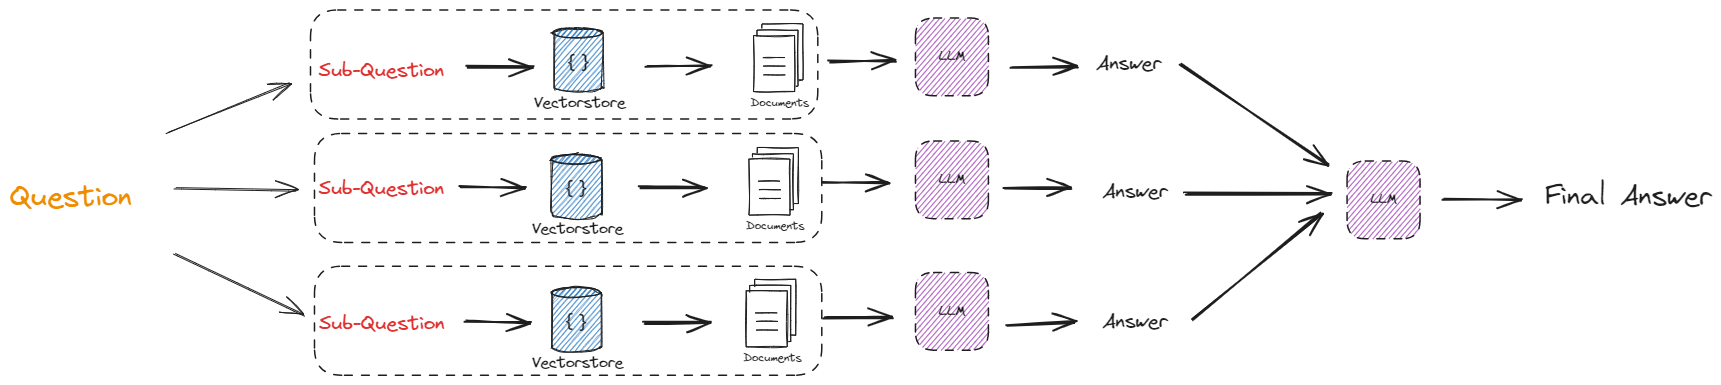

By individually solving sub-questions and then combining all the QnA pairs to solve the bigger picture at once.

In [14]:
from langchain import hub

# RAG prompt
prompt_rag = hub.pull("rlm/rag-prompt")

def retrieve_and_rag(question,prompt_rag,sub_question_generator_chain):
    """RAG on each sub-question"""
    
    # Use our decomposition / 
    sub_questions = sub_question_generator_chain.invoke({"question":question})
    
    # Initialize a list to hold RAG chain results
    rag_results = []
    
    for sub_question in sub_questions:
        
        # Retrieve documents for each sub-question
        retrieved_docs = retriever.get_relevant_documents(sub_question)
        
        # Use retrieved documents and sub-question in RAG chain
        answer = (prompt_rag | model_local | StrOutputParser()).invoke({"context": retrieved_docs, 
                                                                "question": sub_question})
        rag_results.append(answer)
    
    return rag_results,sub_questions

# Wrap the retrieval and RAG process in a RunnableLambda for integration into a chain
answers, questions = retrieve_and_rag(question, prompt_rag, generate_queries_decomposition)

In [15]:
def format_qa_pairs(questions, answers):
    """Format Q and A pairs"""
    
    formatted_string = ""
    for i, (question, answer) in enumerate(zip(questions, answers), start=1):
        formatted_string += f"Question {i}: {question}\nAnswer {i}: {answer}\n\n"
    return formatted_string.strip()

context = format_qa_pairs(questions, answers)

# Prompt
template = """Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer of about 500 characters to the question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | model_local
    | StrOutputParser()
)

final_rag_chain.invoke({"context":context,"question":question})

"Sure, here is an answer to the question:\n\nThe text describes an LLM-powered autonomous agent system where the LLM functions as the agent's brain. The text mentions the potentiality of LLMs extending beyond generating well-written copies, stories, essays, and programs, framing it as a powerful general problem solver.\n\nThe text describes the key components of an LLM-powered autonomous agent system as planning, memory, and self-reflection. The essential features of an LLM-powered autonomous agent system include its brain, LLM, and key components such as planning, task decomposition, and memory.\n\nTherefore, the main components of an LLM-powered autonomous agent system are planning, memory, and self-reflection."